In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

Input DataFrame type: <class 'pandas.core.frame.DataFrame'>
Total instances in original dataset: 690
Instances held for extrapolation: 11
Instances used for training/validation: 679

Target Statistics (final_expandEvts):
Mean (completed instances): 53227800.02
Std Dev (completed instances): 174281183.67
Mean (all data): 750029157.52
Std Dev (all data): 635567837.57

Training Linear Regression on completed instances...
Completed Test Set RMSE: 5536596.9553
Completed Test Set Normalized RMSE: 10.4017%
Completed Test Set sMAPE: 118.29%
Completed Test Set sMdAPE: 190.38%
Completed CV Normalized RMSE: 84.03%


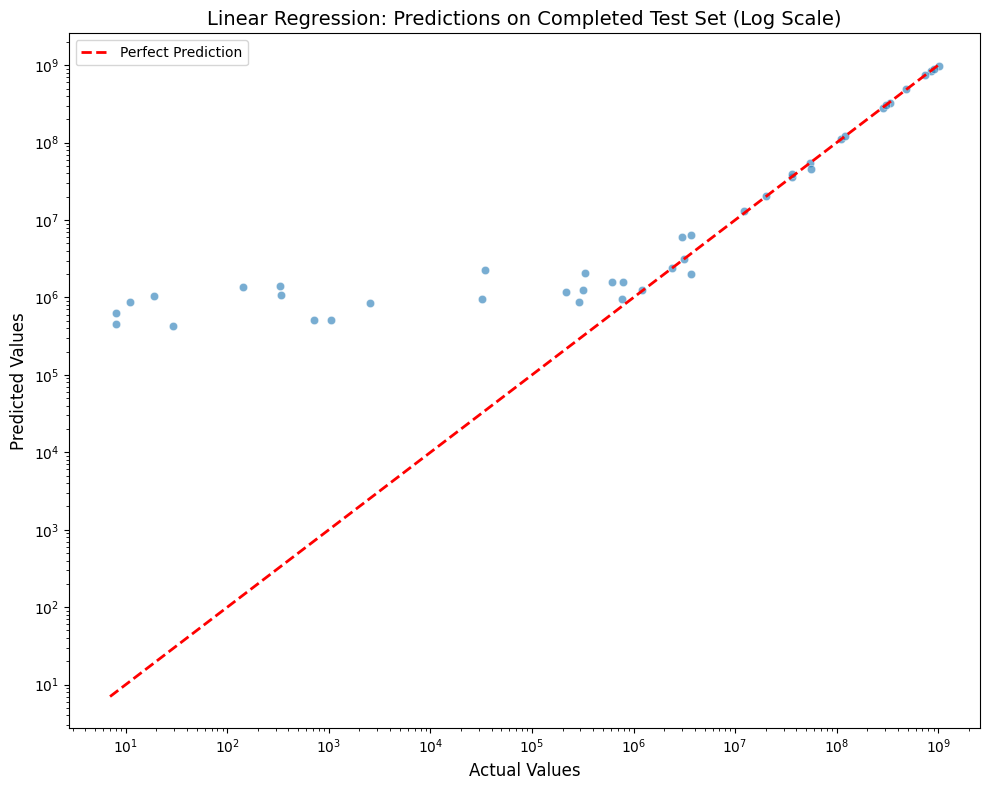


Completed Feature Coefficients (Top 10):
                       feature   coefficient
57  pruneBacktrackEvts_ratio_5  4.500799e+07
51  pruneBacktrackEvts_ratio_2 -2.835556e+07
55  pruneBacktrackEvts_ratio_4 -2.368745e+07
21              avg_expandEvts -2.303088e+07
53  pruneBacktrackEvts_ratio_3  2.139240e+07
50          expandEvts_ratio_2 -2.096125e+07
56          expandEvts_ratio_5 -1.868532e+07
52          expandEvts_ratio_3  1.218121e+07
19                    avg_evts  1.092435e+07
54          expandEvts_ratio_4 -9.186994e+06

Validating on all data (excluding extrapolation set)...
All Model Data RMSE: 573495003530.8584
All Model Data Normalized RMSE: 76463.0278%
All Model Data sMAPE: 166.55%
All Model Data sMdAPE: 200.00%

Performing cross-validation on all model data...
All Model Data CV Normalized RMSE: 1549.41%

Evaluating on held-out extrapolation data...
Extrapolation Set RMSE: 116710765.9390
Extrapolation Set Normalized RMSE: 1.8154%
Extrapolation Set sMAPE: 2.00%
Extrapola

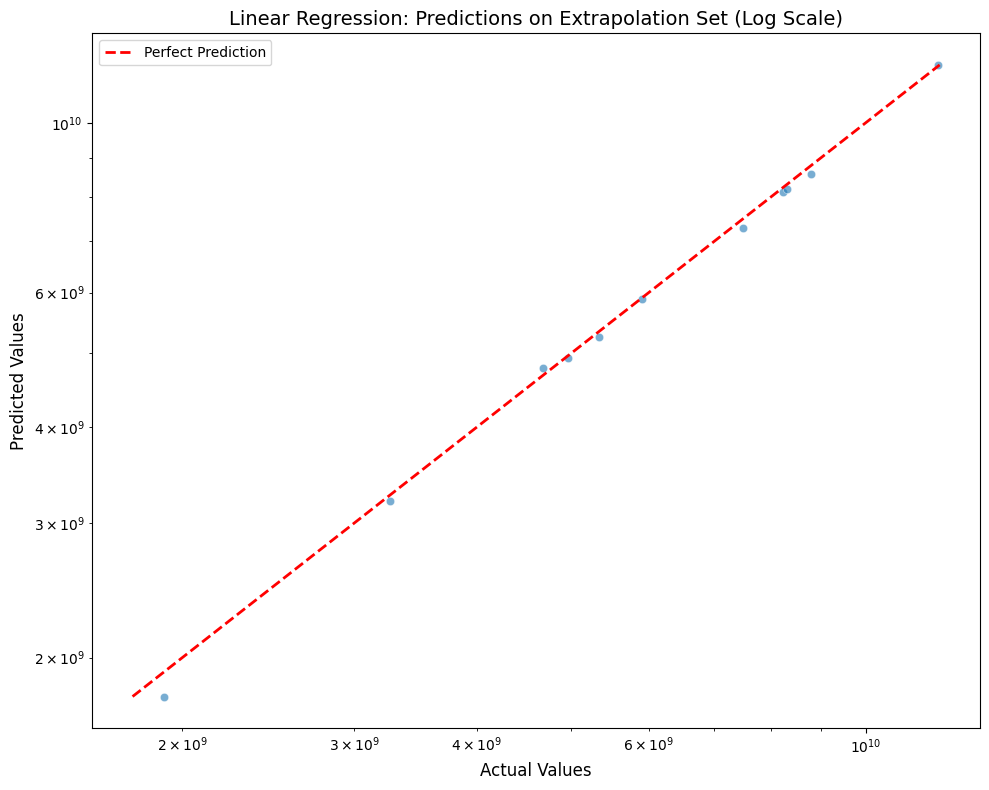


--- Model Performance Metrics (Final Results) ---
Censored Data Normalized RMSE (Test Set): 10.40%
Censored Data CV Normalized RMSE: 84.03%
All Data CV Normalized RMSE: 1549.41%
Extrapolation Normalized RMSE: 0.02%


In [13]:
def train_linear_regression_model(df, include_ratios=False, cv_folds=5, extrapolation_filenames=None, use_log_scale=False):
    """
    Trains a Linear Regression model on completed instances (no timeout) and validates
    on all data and a specific extrapolation set to assess generalizability.
    Includes scatter plots of predicted vs. actual values.

    Parameters:
    - df (pandas.DataFrame): Preprocessed DataFrame with solver features.
    - include_ratios (bool): If True, includes ratio features; if False, excludes them (default: False).
    - cv_folds (int): Number of cross-validation folds (default: 5).
    - extrapolation_filenames (list): List of filenames for the extrapolation test set.
    - use_log_scale (bool): If True, plots on a logarithmic scale (default: False).

    Returns:
    - dict: Contains relative error metrics, CV scores, and feature coefficients for
            completed test set, all data, and the new extrapolation set.
    """
    try:
        # Validate input
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Input 'df' must be a pandas DataFrame, got {type(df)}")
        print(f"Input DataFrame type: {type(df)}")

        # Define the extrapolation filenames if not provided
        if extrapolation_filenames is None:
            extrapolation_filenames = [
                'n27k3_v1.txt', 'n27k3_v2.txt', 'n27k3_v3.txt', 'n27k3_v4.txt',
                'n28k3_v1.txt', 'n28k3_v2.txt', 'n28k3_v3.txt', 'n28k3_v4.txt',
                'n28k3_v5.txt', 'n29k3_v1.txt', 'n29k3_v2.txt'
            ]
            
        # Separate extrapolation data
        df_extrapolation = df[df['filename'].isin(extrapolation_filenames)].copy()
        df_model_data = df[~df['filename'].isin(extrapolation_filenames)].copy()
        
        if df_extrapolation.empty:
            print("Warning: Extrapolation data not found in the DataFrame.")
            
        print(f"Total instances in original dataset: {len(df)}")
        print(f"Instances held for extrapolation: {len(df_extrapolation)}")
        print(f"Instances used for training/validation: {len(df_model_data)}")

        # Feature selection
        exclude_cols = ['filename', 'final_expandEvts', 'stop_iter', 'final_maxStackDepth']
        if not include_ratios:
            exclude_cols.extend([f'expandEvts_ratio_{i}' for i in range(1, 6)])
            exclude_cols.extend([f'pruneBacktrackEvts_ratio_{i}' for i in range(1, 6)])
        features = [col for col in df.columns if col not in exclude_cols and col != 'censored']

        # Print target statistics (on the model data, excluding extrapolation)
        print("\nTarget Statistics (final_expandEvts):")
        mean_completed = df_model_data[df_model_data['censored'] == 0]['final_expandEvts'].mean()
        std_completed = df_model_data[df_model_data['censored'] == 0]['final_expandEvts'].std()
        mean_all = df_model_data['final_expandEvts'].mean()
        std_all = df_model_data['final_expandEvts'].std()
        print(f"Mean (completed instances): {mean_completed:.2f}")
        print(f"Std Dev (completed instances): {std_completed:.2f}")
        print(f"Mean (all data): {mean_all:.2f}")
        print(f"Std Dev (all data): {std_all:.2f}")

        # Define relative error metrics
        def calculate_smape(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            denominator = np.abs(y_true) + np.abs(y_pred)
            mask = denominator != 0
            if mask.sum() == 0:
                return np.nan
            smape = np.mean(2 * np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100
            return smape

        def calculate_smdape(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            denominator = np.abs(y_true) + np.abs(y_pred)
            mask = denominator != 0
            if mask.sum() == 0:
                return np.nan
            smape_terms = 2 * np.abs(y_true[mask] - y_pred[mask]) / denominator[mask] * 100
            return np.median(smape_terms)

        def calculate_normalized_rmse(y_true, y_pred, mean_y):
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            return rmse / mean_y if mean_y != 0 else np.nan
        
        # Train on completed data (from the model data set)
        print("\nTraining Linear Regression on completed instances...")
        df_completed = df_model_data[df_model_data['censored'] == 0].copy()
        if df_completed.empty:
            print("Warning: No completed instances found for training. Exiting.")
            return None
            
        X_completed = df_completed[features]
        y_completed = df_completed['final_expandEvts']
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_completed, y_completed, test_size=0.2, random_state=42)
        
        lr_model = LinearRegression()
        lr_model.fit(X_train_c, y_train_c)
        
        # Evaluate on completed test set
        y_pred_c = lr_model.predict(X_test_c)
        rmse_completed = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
        norm_rmse_completed = calculate_normalized_rmse(y_test_c, y_pred_c, mean_completed)
        smape_completed = calculate_smape(y_test_c, y_pred_c)
        smdape_completed = calculate_smdape(y_test_c, y_pred_c)
        
        # Cross-validation with neg_root_mean_squared_error
        cv_scores = cross_val_score(lr_model, X_completed, y_completed, cv=cv_folds, scoring='neg_root_mean_squared_error')
        cv_nrmse_completed = (-cv_scores.mean() / mean_completed) * 100
        
        print(f"Completed Test Set RMSE: {rmse_completed:.4f}")
        print(f"Completed Test Set Normalized RMSE: {norm_rmse_completed:.4%}")
        print(f"Completed Test Set sMAPE: {smape_completed:.2f}%")
        print(f"Completed Test Set sMdAPE: {smdape_completed:.2f}%")
        print(f"Completed CV Normalized RMSE: {cv_nrmse_completed:.2f}%")

        # Generate and display the plot for the completed test set
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(x=y_test_c, y=y_pred_c, alpha=0.6, color="#1f77b4")
        
        if use_log_scale:
            # Filter out non-positive values for log scale
            y_test_c_plot = y_test_c[y_test_c > 0]
            y_pred_c_plot = y_pred_c[y_pred_c > 0]
            # Use log scale
            plt.xscale('log')
            plt.yscale('log')
            # Plot the perfect prediction line on log scale
            min_val_c = min(min(y_test_c_plot), min(y_pred_c_plot))
            max_val_c = max(max(y_test_c_plot), max(y_pred_c_plot))
            ax.plot([min_val_c, max_val_c], [min_val_c, max_val_c], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
            plt.title("Linear Regression: Predictions on Completed Test Set (Log Scale)", fontsize=14)
        else:
            min_val_c = min(min(y_test_c), min(y_pred_c))
            max_val_c = max(max(y_test_c), max(y_pred_c))
            ax.plot([min_val_c, max_val_c], [min_val_c, max_val_c], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
            plt.title("Linear Regression: Predictions on Completed Test Set", fontsize=14)
            
        plt.xlabel("Actual Values", fontsize=12)
        plt.ylabel("Predicted Values", fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Feature coefficients
        coefficients = pd.DataFrame({
            'feature': X_completed.columns,
            'coefficient': lr_model.coef_
        }).sort_values('coefficient', key=abs, ascending=False)
        print("\nCompleted Feature Coefficients (Top 10):")
        print(coefficients.head(10))

        # Validate on all data (from the model data set)
        print("\nValidating on all data (excluding extrapolation set)...")
        X_all = df_model_data[features]
        y_all = df_model_data['final_expandEvts']
        y_pred_all = lr_model.predict(X_all)
        rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all))
        norm_rmse_all = calculate_normalized_rmse(y_all, y_pred_all, mean_all)
        smape_all = calculate_smape(y_all, y_pred_all)
        smdape_all = calculate_smdape(y_all, y_pred_all)
        print(f"All Model Data RMSE: {rmse_all:.4f}")
        print(f"All Model Data Normalized RMSE: {norm_rmse_all:.4%}")
        print(f"All Model Data sMAPE: {smape_all:.2f}%")
        print(f"All Model Data sMdAPE: {smdape_all:.2f}%")
        
        # Cross-validation for all model data
        print("\nPerforming cross-validation on all model data...")
        cv_scores_all = cross_val_score(lr_model, X_all, y_all, cv=cv_folds, scoring='neg_root_mean_squared_error')
        cv_nrmse_all = (-cv_scores_all.mean() / mean_all) * 100
        print(f"All Model Data CV Normalized RMSE: {cv_nrmse_all:.2f}%")

        # Evaluate on the held-out extrapolation data
        print("\nEvaluating on held-out extrapolation data...")
        X_extrapolation = df_extrapolation[features]
        y_extrapolation = df_extrapolation['final_expandEvts']
        y_pred_extrapolation = lr_model.predict(X_extrapolation)

        mean_extrapolation = y_extrapolation.mean()
        rmse_extrapolation = np.sqrt(mean_squared_error(y_extrapolation, y_pred_extrapolation))
        norm_rmse_extrapolation = calculate_normalized_rmse(y_extrapolation, y_pred_extrapolation, mean_extrapolation)
        smape_extrapolation = calculate_smape(y_extrapolation, y_pred_extrapolation)
        smdape_extrapolation = calculate_smdape(y_extrapolation, y_pred_extrapolation)
        
        print(f"Extrapolation Set RMSE: {rmse_extrapolation:.4f}")
        print(f"Extrapolation Set Normalized RMSE: {norm_rmse_extrapolation:.4%}")
        print(f"Extrapolation Set sMAPE: {smape_extrapolation:.2f}%")
        print(f"Extrapolation Set sMdAPE: {smdape_extrapolation:.2f}%")

        # Generate and display the plot for the held-out extrapolation set
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(x=y_extrapolation, y=y_pred_extrapolation, alpha=0.6, color="#1f77b4")
        
        if use_log_scale:
            # Filter out non-positive values for log scale
            y_extrapolation_plot = y_extrapolation[y_extrapolation > 0]
            y_pred_extrapolation_plot = y_pred_extrapolation[y_pred_extrapolation > 0]
            # Use log scale
            plt.xscale('log')
            plt.yscale('log')
            # Plot the perfect prediction line on log scale
            min_val_e = min(min(y_extrapolation_plot), min(y_pred_extrapolation_plot))
            max_val_e = max(max(y_extrapolation_plot), max(y_pred_extrapolation_plot))
            ax.plot([min_val_e, max_val_e], [min_val_e, max_val_e], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
            plt.title("Linear Regression: Predictions on Extrapolation Set (Log Scale)", fontsize=14)
        else:
            min_val_e = min(min(y_extrapolation), min(y_pred_extrapolation))
            max_val_e = max(max(y_extrapolation), max(y_pred_extrapolation))
            ax.plot([min_val_e, max_val_e], [min_val_e, max_val_e], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
            plt.title("Linear Regression: Predictions on Extrapolation Set", fontsize=14)

        plt.xlabel("Actual Values", fontsize=12)
        plt.ylabel("Predicted Values", fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return {
            'rmse_completed_test': rmse_completed,
            'norm_rmse_completed_test': norm_rmse_completed,
            'smape_completed_test': smape_completed,
            'smdape_completed_test': smdape_completed,
            'cv_nrmse_completed': cv_nrmse_completed,
            'rmse_all': rmse_all,
            'norm_rmse_all': norm_rmse_all,
            'smape_all': smape_all,
            'smdape_all': smdape_all,
            'cv_nrmse_all': cv_nrmse_all,
            'feature_coefficients': coefficients.to_dict('records'),
            'rmse_extrapolation': rmse_extrapolation,
            'norm_rmse_extrapolation': norm_rmse_extrapolation,
            'smape_extrapolation': smape_extrapolation,
            'smdape_extrapolation': smdape_extrapolation,
        }

    except Exception as e:
        print(f"Error in train_linear_regression_model: {e}")
        return None

# --- Main execution block ---
df = pd.read_excel("structured_data.xlsx")
# The use_log_scale=True argument is now added to visualize the errors better
results = train_linear_regression_model(df, include_ratios=True, use_log_scale=True)
if results:
    print("\n--- Model Performance Metrics (Final Results) ---")
    print(f"Censored Data Normalized RMSE (Test Set): {results['norm_rmse_completed_test']:.2%}")
    print(f"Censored Data CV Normalized RMSE: {results['cv_nrmse_completed']:.2f}%")
    print(f"All Data CV Normalized RMSE: {results['cv_nrmse_all']:.2f}%")
    print(f"Extrapolation Normalized RMSE: {results['norm_rmse_extrapolation']:.2f}%")